<a href="https://colab.research.google.com/github/pds2122/capstone-project-kabobe/blob/main/models/model_ml_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost

##Install and Import

In [ ]:
!pip install ndjson --quiet

In [ ]:
import pandas as pd
import numpy as np
import ndjson
import gzip
from google.colab import drive
from pathlib import Path


from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics

##Load Train & Test

In [ ]:
#train
path_train = Path('/content/drive/MyDrive/industry_data_processed/data/final/df_train_de_sentiment.ndjson')

with open(path_train) as f:
    data = ndjson.load(f)
df_train = pd.DataFrame(data)

In [ ]:
#test
path_test = Path('/content/drive/MyDrive/industry_data_processed/data/final/df_test_de_sentiment.ndjson')

with open(path_test) as f:
    data = ndjson.load(f)
df_test = pd.DataFrame(data)

In [ ]:
df_train.head(2)

,url,industry,industry_label,img_alt,h1,h2,h3,strong,bold,lang_code,figcaption,pure_text,title,concatenated,sentiment_analysis
0,http://www.kaiser-personal-service.de,137,Human Resources,,,aktuell Stellenangebot,,,,de,,Kaiser Personal Service Impressum Datumenschut...,Kaiser Personal Service,aktuell Stellenangebot de Kaiser Persona...,0.00
1,http://www.brandseven.com,96,Information Technology and Services,Brandseven Energy Cockpit Innovation Lab Brand...,Maßgeschneiderte Vertriebstool Stadtwerk Evu s,Brandseven Go Remote Biohymethcontrol richtig ...,Energy Cockpit Edition,Beispiel Gedankenexperiment Intervention Ergebnis,,de,,Brandseven digital Lösung Energiewirtschaft se...,Brandseven digital Lösung Energiewirtschaft se...,Brandseven Energy Cockpit Innovation Lab Brand...,-0.11


In [ ]:
df_test.head(2)

,url,industry,industry_label,img_alt,h1,h2,h3,strong,bold,lang_code,figcaption,pure_text,title,concatenated,sentiment_analysis
0,http://www.expert.de,133,Wholesale,Expert Logo Expert Logo Expert Logo Angebot Wo...,,Highlight,,registrieren Angebot Kinoerlebnis Haus kaufen ...,,de,,Elektromarkt Nähe Online Shop Expert Warenkorb...,Elektromarkt Nähe Online Shop Expert,Expert Logo Expert Logo Expert Logo Angebot Wo...,0.31
1,http://www.weight-watchers.de,13,Medical Practice,neu Meinww Meinww mobil Vorschau Fiton Video W...,abnehmen ww Weight Watchers ww Deutschland,kurz Zeit Studios Ort vorübergehend schließen ...,bereit loslegen Mitglied vormachen,ww App kurz Zeit Monat kostenlos ww Pro “ exkl...,,de,,abnehmen ww Weight Watchers ww Deutschland dir...,abnehmen ww Weight Watchers ww Deutschland,neu Meinww Meinww mobil Vorschau Fiton Video W...,0.12


###Data Preperation

In [ ]:
train_X = df_train.drop(['url', 'industry', 'industry_label'], axis=1).copy()
train_y = df_train['industry_label'].copy().values.reshape(-1, 1)

In [ ]:
test_X = df_test.drop(['url', 'industry', 'industry_label'], axis=1).copy()
test_y = df_test['industry_label'].copy().values.reshape(-1, 1)

In [ ]:
train_y.tolist()
test_y.tolist()

[['Wholesale'],
 ['Medical Practice'],
 ['Financial Services'],
 ['Human Resources'],
 ['Renewables & Environment'],
 ['Marketing and Advertising'],
 ['Wholesale'],
 ['Medical Practice'],
 ['Mechanical or Industrial Engineering'],
 ['Marketing and Advertising'],
 ['Financial Services'],
 ['Medical Practice'],
 ['Leisure, Travel & Tourism'],
 ['Renewables & Environment'],
 ['Mechanical or Industrial Engineering'],
 ['Legal Services'],
 ['Information Technology and Services'],
 ['Wholesale'],
 ['Management Consulting'],
 ['Information Technology and Services'],
 ['Marketing and Advertising'],
 ['Wholesale'],
 ['Medical Practice'],
 ['Financial Services'],
 ['Mechanical or Industrial Engineering'],
 ['Information Technology and Services'],
 ['Management Consulting'],
 ['Information Technology and Services'],
 ['Information Technology and Services'],
 ['Marketing and Advertising'],
 ['Financial Services'],
 ['Management Consulting'],
 ['Construction'],
 ['Mechanical or Industrial Engineeri

In [ ]:
train_X.shape, test_X.shape

((16809, 12), (8396, 12))

##Model

- from Hyperparameter-Tuning (without scale_pos_weight):

XGBClassifier(colsample_bytree=0.5, gamma=0.4, learning rate=0.05, max_depth=15,
              min_child_weight=5, num_boosting_rounds=100,
              objective='multi:softprob', random_state=42)

- with scale_pos_weight:

XGBClassifier(colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=5,
              min_child_weight=3, num_boosting_rounds=20,
              objective='multi:softprob', random_state=42, scale_pos_weight=90)

In [ ]:
# from first tuning (without scale_pos_weight):
'''xgb_model = xgb.XGBClassifier(colsample_bytree=0.5, gamma=0.4, learning_rate=0.05, max_depth=15,
              min_child_weight=5, num_boosting_rounds=100,
              objective='multi:softprob', random_state=42)'''

# with scale_pos_weight:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=5,
              min_child_weight=3, num_boosting_rounds=20,
              objective='multi:softprob', random_state=42, scale_pos_weight=90)

# xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

###Hyperparameter Tuning

first: shorten datasets for hyperparametertuning (due to time..)

In [ ]:
train_half = df_train.sample(frac=0.3).copy()
test_half = df_test.sample(frac=0.1).copy()

In [ ]:
train_X = train_half.drop(['url', 'industry', 'industry_label'], axis=1).copy()
train_y = train_half['industry_label'].copy().values.reshape(-1, 1)

test_X = test_half.drop(['url', 'industry', 'industry_label'], axis=1).copy()
test_y = test_half['industry_label'].copy().values.reshape(-1, 1)

In [ ]:
train_y.tolist()
test_y.tolist()

train_X.shape, train_y.shape

((5043, 12), (5043, 1))

In [ ]:
column_trans = ColumnTransformer(transformers=[
        ('imputer', SimpleImputer(strategy='median'), ['sentiment_analysis']),
        ('tnf', TfidfVectorizer(), 'concatenated')], remainder = 'drop', verbose_feature_names_out=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = {
    'num_boosting_rounds':[20, 50, 75, 100],
    'learning rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth':[5, 10, 15, 20],
    'min_child_weight': [1,3,5,7, 10, 15, 20],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree':[0.3, 0.4, 0.5, 0.7],
    'scale_pos_weight':[30, 50, 80, 90, 100]
}

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
# SAMPLE WEIGHT IS NOT SUPPORTED BY PIPELINE...

#compute_sample_weight
'''sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train_y.ravel() #provide your own target name
)

pipeline.fit(train_X, train_y.ravel(), sample_weight=sample_weights)'''

In [ ]:
random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3)

pipeline = Pipeline(steps=[('t', column_trans), ('m',random_search)])

In [ ]:
pipeline.fit(train_X, train_y.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning,


Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['sentiment_analysis']),
                                                 ('tnf', TfidfVectorizer(),
                                                  'concatenated')],
                                   verbose_feature_names_out=False)),
                ('m',
                 RandomizedSearchCV(cv=3,
                                    estimator=XGBClassifier(objective='multi:softprob',
                                                            random_state=42),
                                    n_iter=5, n_jobs=-1,
                                    param_distributions={'colsample_bytree': [0.3,
                                                                              0.4,
                                                                              0.5,
        

In [ ]:
random_search.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.3,
 'learning rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 3,
 'num_boosting_rounds': 20,
 'scale_pos_weight': 90}

In [ ]:
random_search.best_estimator_

XGBClassifier(colsample_bytree=0.5, gamma=0.3, learning rate=0.2, max_depth=5,
              min_child_weight=3, num_boosting_rounds=20,
              objective='multi:softprob', random_state=42, scale_pos_weight=90)

##continue with "Model"

In [ ]:
column_trans = ColumnTransformer(transformers=[
        ('imputer', SimpleImputer(strategy='median'), ['sentiment_analysis']),
        ('tnf', TfidfVectorizer(), 'concatenated')], remainder = 'drop', verbose_feature_names_out=False)

In [ ]:
pipeline = Pipeline(steps=[('t', column_trans), ('m',xgb_model)])

In [ ]:
pipeline.fit(train_X, train_y.ravel())

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['sentiment_analysis']),
                                                 ('tnf', TfidfVectorizer(),
                                                  'concatenated')],
                                   verbose_feature_names_out=False)),
                ('m',
                 XGBClassifier(colsample_bytree=0.5, gamma=0.3,
                               learning_rate=0.2, max_depth=5,
                               min_child_weight=3, num_boosting_rounds=20,
                               objective='multi:softprob', random_state=42,
                               scale_pos_weight=90))])

In [ ]:
#score
score = pipeline.score(test_X, test_y.ravel())
score

0.6528108623153883

In [ ]:
predicted = pipeline.predict(test_X)

##Metrics

In [ ]:
xgb_report = metrics.classification_report(test_y.flatten().tolist(), 
                                           predicted.tolist(), 
                                           labels=test_y.flatten().tolist(),
                                           output_dict=True)

In [ ]:
xgb_report = metrics.classification_report(test_y.flatten().tolist(), predicted.tolist(), labels=test_y.flatten().tolist(), output_dict=True)

In [ ]:
pd.DataFrame(xgb_report).T

,precision,recall,f1-score,support
Wholesale,0.631206,0.570513,0.599327,4.680000e+02
Medical Practice,0.801802,0.675949,0.733516,3.950000e+02
Financial Services,0.842500,0.718550,0.775604,4.690000e+02
Human Resources,0.789809,0.568807,0.661333,2.180000e+02
Renewables & Environment,0.709957,0.565517,0.629559,2.900000e+02
Marketing and Advertising,0.664399,0.706024,0.684579,8.300000e+02
Mechanical or Industrial Engineering,0.552652,0.695219,0.615792,1.004000e+03
"Leisure, Travel & Tourism",0.885246,0.729730,0.800000,1.480000e+02
Legal Services,0.914286,0.711111,0.800000,1.350000e+02
Information Technology and Services,0.587886,0.830640,0.688492,1.671000e+03


Confusion Matrix

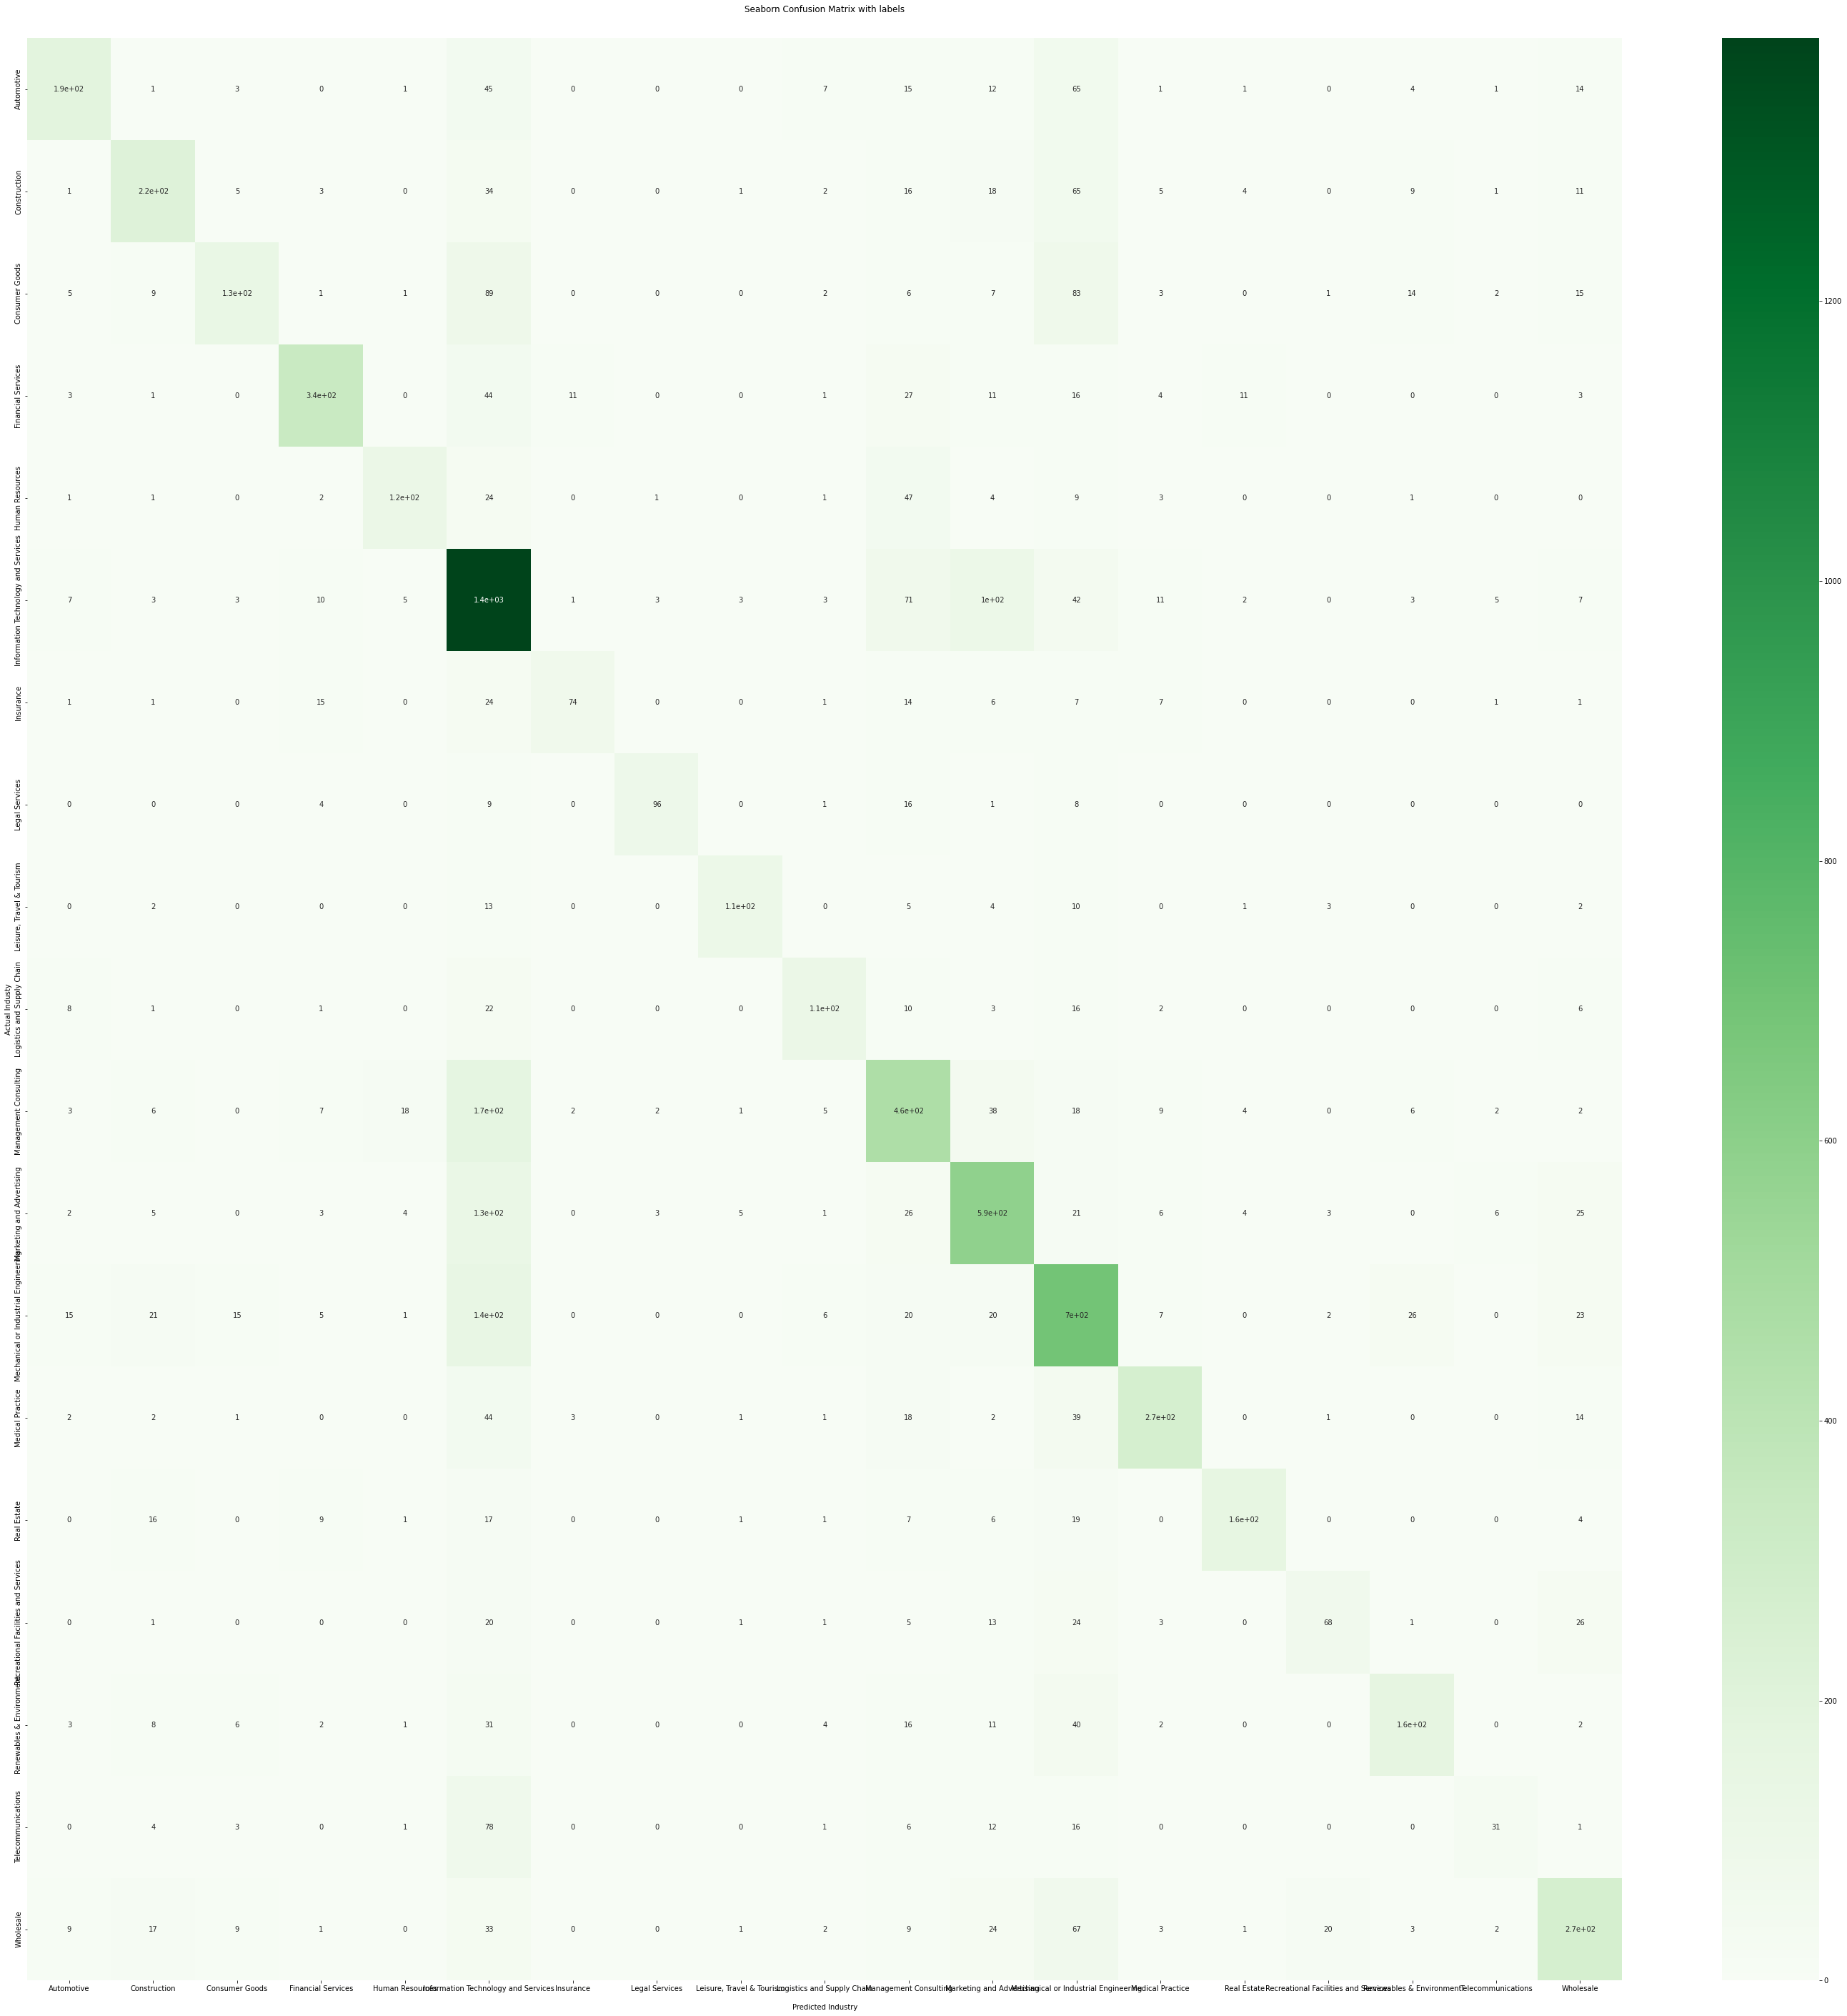

In [ ]:
cf_matrix = metrics.confusion_matrix(test_y, predicted)

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 50))

sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Industry')
ax.set_ylabel('Actual Industy');

# list of labels
industries = df_train['industry_label'].tolist()
industries = sorted(set(industries))

# ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(industries)
ax.yaxis.set_ticklabels(industries)

# display the visualization of the Confusion Matrix.
plt.show()

##Imbalanced Data

no improvement..

In [ ]:
#Combination: Under- and Oversampling
from imblearn.combine import SMOTETomek

In [ ]:
smote_tomek = SMOTETomek(random_state=0)

In [ ]:
X_resampled_both, y_resampled_both = smote_tomek.fit_resample(train_X, train_y)

##Load & Save Model

In [ ]:
import pickle

In [ ]:
# save model and vectorizer to file
with open('xgboost_tfidf_normal.pkl', 'wb') as f:
    pickle.dump((vectorizer, xgb_model), f)

    #tnf, imputer

In [ ]:
#load
data_path = Path('/content/drive/MyDrive/Models/xgboost/')
file_name = 'xgboost_tfidf_normal.pkl'

with open(data_path/file_name, 'rb') as f:
    vectorizer_loaded, xgb_model_loaded = pickle.load(f)

with pipeline:

In [ ]:
#joblib library!
import joblib

In [ ]:
#save
joblib.dump(pipeline, 'xgbpipe_tuned.joblib')

['xgbpipe_tuned.joblib']

In [ ]:
#open
same_pipe = joblib.load('/content/drive/MyDrive/PDS/xgbpipe.joblib')

##Results

**Train dataset with regular train-test-split (just german data)**

* no speicals added
  * score 0.732

* with smote_tomek 
  * score 0.728


**Pre-splitten train and test dataset (just german data)**

* with sentiment_analysis
  * score 0.627

* with sentiment_analysis and parameter tuning
  * score 0.650
